In [42]:
%cd D:\研究所\論文研究\新生兒

D:\研究所\論文研究\新生兒


In [43]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)
import tensorflow as tf
import copy
from torch.autograd import Variable
import torch.optim as optim
import time
import math

In [44]:
data_df = pd.read_csv("birthweight_test.csv")
data_df["AGE"] = np.log(data_df["AGE"])
data_df["lwt"] = np.log(data_df["lwt"])
data_df.dropna(inplace=True)

In [45]:
data_df['bwt'].describe()
threshold_for_infer = (2500 - data_df['bwt'].mean())/data_df['bwt'].std() #-0.5879256744378174

In [46]:
data_df['bwt'] = (data_df['bwt']-data_df['bwt'].mean())/data_df['bwt'].std()

In [165]:
data_df

,AGE,lwt,race,smoke,ptl,ht,ui,bwt
0,2.944439,5.204007,2.0,0.0,0.0,0.0,1.0,-0.569484
1,3.496508,5.043425,3.0,0.0,0.0,0.0,0.0,-0.531229
2,2.995732,4.653960,1.0,1.0,0.0,0.0,0.0,-0.523032
3,3.044522,4.682131,1.0,1.0,0.0,0.0,1.0,-0.472481
4,2.890372,4.672829,1.0,1.0,0.0,0.0,1.0,-0.464284
...,...,...,...,...,...,...,...,...
184,3.332205,4.553877,1.0,1.0,0.0,0.0,0.0,-0.647360
185,2.639057,4.605170,3.0,0.0,0.0,0.0,0.0,-0.607739
186,3.135494,4.543295,3.0,1.0,0.0,0.0,0.0,-0.607739
187,2.833213,4.955827,2.0,0.0,0.0,1.0,0.0,-0.607739


In [48]:
def NOT_duplicate(df):
    print(f'資料總數:{len(df)}')
    a = df.duplicated(keep='first', subset = df.columns[:-1])#'first' #X相同, y相同or不同，都刪除
    count = 0
    for i in range(len(a)):
        if a[i] == True:
            count += 1
    print(f'-----------------共有{count}筆完全重複資料-----------------')
    df = df.drop_duplicates(keep='first', subset = df.columns[:-1])
    print('已刪除重複資料')
    print(f'資料總數:{len(df)}')
    return df
data_df = NOT_duplicate(data_df)

資料總數:189
-----------------共有7筆完全重複資料-----------------
已刪除重複資料
資料總數:182


In [49]:
def check_duplicate(df):
    print(f'重複資料的index: ')
    for i in range(len(data_df)):
        for j in range(len(data_df)):
            if np.array_equal(data_df.iloc[i].values, data_df.iloc[j].values) and i != j:
                print(i)

#check_duplicate(data_df)

In [50]:
x = data_df.iloc[:,:-1]
y = data_df.iloc[:,-1]
x = x.to_numpy()
y = y.to_numpy()

In [51]:
# x_train, x_test, y_train, y_test = train_test_split(x, y ,test_size=0.3, random_state=0) 

### CSI(安寧)

In [272]:
class Network(torch.nn.Module):
    def __init__(self, x_train_scaled, nb_neuro, y_train_scaled):
        super(Network, self).__init__() #使用父類別(torch.nn.Module)的__init__()
        self.linear1 = torch.nn.Linear(x_train_scaled.shape[1], nb_neuro)
        self.linear2 = torch.nn.Linear(nb_neuro, y_train_scaled.shape[1])
        #self.dropout = torch.nn.Dropout(0.3)
        # Stop criteria - threshold
        self.threshold_for_error = 0.8
        self.threshold_for_lr = 1e-4
        
        # Input data
        self.x = torch.FloatTensor(x_train_scaled)
        self.y = torch.FloatTensor(y_train_scaled)
        # Whether the network is acceptable
        self.acceptable = False
        # Learning rate
        self.learning_rate = 1e-2 #1e-2

        #self.yo = torch.tensor([1])
        

    def setData(self, x_train_scaled, y_train_scaled):
        self.x = torch.FloatTensor(x_train_scaled)
        self.y = torch.FloatTensor(y_train_scaled)
        
    def addData(self, new_x_train, new_y_train):
        self.x = torch.FloatTensor(new_x_train[0])
        self.y = torch.FloatTensor(new_y_train[0])
    
        # forward operation
    def forward(self, reg_t=0):
        
        h_relu = self.linear1(self.x).clamp(min=0)
        yo = self.linear2(h_relu)
        reg_term= reg_t/((self.linear2.bias.data.shape[0]*(self.linear2.weight.data.shape[1]+1)) +   (self.linear2.weight.data.shape[1]*(self.linear1.weight.data.shape[1]+1)))*(torch.sum(torch.pow(self.linear2.bias.data,2))+torch.sum(torch.pow(self.linear2.weight.data,2))+torch.sum(torch.pow(self.linear1.bias.data,2))+torch.sum(torch.pow(self.linear1.weight.data,2)))
        loss = torch.nn.functional.mse_loss(yo,self.y) + reg_term
        return (yo,loss)


    # backward operation
    def backward_Adam(self,loss):    
        optimizer = optim.Adam(network.parameters(), lr=self.learning_rate, weight_decay=0.1) #优化函数，model.parameters()为该实例中可优化的参数，lr为参数优化的选项（学习率等）
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    def backward_Adadelta(self,loss):
        optimizer =optim.Adadelta(network.parameters(), lr=self.learning_rate,rho=0.9, eps=1e-06, weight_decay=1) #weight_decay = 0
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [273]:
def initializing(network, initial_x, initial_y):
    print("<<  Initializing Start  >>")
    initial_x=torch.FloatTensor(initial_x)
    initial_y=torch.FloatTensor(initial_y)
    min_y = min(initial_y)    
    res_y = initial_y-min_y
    reg = LinearRegression().fit(initial_x, res_y)

    network.linear1.weight.data = Variable(torch.FloatTensor(reg.coef_))
    network.linear1.bias.data = Variable(torch.FloatTensor(reg.intercept_))
    network.linear2.weight.data = Variable(torch.ones(1,1))
    network.linear2.bias.data = Variable(min_y)
    #print(f'linear2.bias : {network.linear2.bias.data}')
    
    network.acceptable =True
    print(f'network.linear1 的 權重 : {network.linear1.weight.data}\n')
    print(f'network.linear1 的 偏差值 : {network.linear1.bias.data}\n')
    print(f'network.linear2 的 權重 : {network.linear2.weight.data}\n')
    print(f'network.linear2 的 偏差值 : {network.linear2.bias.data}\n')
    print("<<  Initializing End  >>")

In [274]:
def selecting(network, x_train_scaled, y_train_scaled):   #把全部資料一筆一筆跑進來，依照error值由小到大排列，從最小的開始訓練
    print("<<  Selecting Start  >>")
    print(" ------------------------------")
    residual = []
    train_x=torch.randn(1,7)
    train_y=torch.randn(1,1)
    temp_network = copy.deepcopy(network)
    for i in range(x_train_scaled.shape[0]):
        train_x=torch.FloatTensor(x_train_scaled[i])
        train_y=torch.FloatTensor(y_train_scaled[i])
        temp_network.x=train_x
        temp_network.y=train_y
        residual_calculate=temp_network.forward()[1].item()
        #print(residual_calculate)
        residual.append(residual_calculate)
    min_residual = min(residual)
    print(" Min Loss selected for this round : %f"%min_residual)
#     print(min_loss)
    min_residual_index = residual.index(min_residual)
    print(" ------------------------------")
    print("<<  Selecting End  >>\n")
    return (x_train_scaled[min_residual_index],y_train_scaled[min_residual_index],min_residual_index)
    

In [275]:
def selecting_pos(network, x_train_scaled, y_train_scaled):
    print("<<  Selecting(POS) Start  >>")
    print(" ------------------------------")
    print("<<  Selecting End  >>\n")
    return (x_train_scaled[0],y_train_scaled[0], 0)

In [276]:
def matching(network):
#     matching_count = 0  #calculate matching 
    print("<<  Matching Start  >>")
    print(" ------------------------------")
    network.learning_rate = 1e-3
    
    while True:
        
        yo, loss = network.forward()
        if torch.all(torch.abs(yo-network.y) <= network.threshold_for_error):   #learning goal直接過，進regularizing
            #print("Learning goal : %f <= %f " %(torch.abs(yo-network.y),network.threshold_for_error))
            network.acceptable = True
            print("Matching finished - the network is acceptable")
#             matching_count += 1
            print(" ------------------------------")
            print("<<  Matching Completed  >>\n")
            return (network)

        else:                                                       #learning goal沒過，進matching，調整weight
            network_pre = copy.deepcopy(network)
            loss_pre = loss
            
            network.backward_Adam(loss)
            yo, loss = network.forward()

            #調整完的loss是否變小，作為model是否調整好的依據
            if loss < loss_pre: #因為到了local minimum，所以導致loss = loss_pre，就會一直卡在這個部分，導致最後learning_rate過大，程式無法計算                        
                #print("Loss: %f < %f , learning rate: %f, tuning the learning rate more bigger." %(loss,loss_pre,network.learning_rate))
                network.learning_rate *= 1.2

            else:
                network = network_pre
                if network.learning_rate <= network.threshold_for_lr:  #看learning rate是否變太小
                    #print("Loss: %f <= %f , learning rate: %f, Oops!!! Learning rate is tooooo SMALL." %(loss,loss_pre,network.learning_rate))
                    print("Matching finished - the network is Unacceptable  ")
                    print("Restore the network  ")
                    print(" ------------------------------")
                    print("<<  Matching Failed  >>\n")
                    network.acceptable = False
                    return (network)

                else:                                                 #learning rate還沒變太小，可以繼續調整
                    #print("Loss: %f <= %f , learning rate: %f, tuning the learning rate more smaller." %(loss,loss_pre,network.learning_rate))
                    network.learning_rate *= 0.7

In [277]:
def re_matching(network):
    print("<<  Matching Start (Reorganizing)  >>")
    print(" ------------------------------")
    network.learning_rate = 1e-3
    
    while True:
        
        yo, loss = network.forward()
        if torch.all(torch.abs(yo-network.y) <= network.threshold_for_error):    #沒問題
            network.acceptable = True
            print("Matching (Reorganizing) finished - the network is acceptable")
            print(" ------------------------------")
            print("<<  Matching Completed (Reorganizing) >>\n")
            return (network)

        else:                #沒問題                                             
            
            network_pre = copy.deepcopy(network)
            loss_pre = loss
            
            network.backward_Adam(loss)

            yo, loss = network.forward()

            if loss < loss_pre: #因為到了local minimum，所以導致loss = loss_pre，就會一直卡在這個部分，導致最後learning_rate過大，程式無法計算
                #print(f"Loss: {loss} < {loss_pre}, learning rate: {network.learning_rate}, tuning the learning rate more bigger.")
                network.learning_rate *= 1.2

            else:

                network = network_pre

                if network.learning_rate <= network.threshold_for_lr:     #看learning rate是否變太小
                    #print(f"Loss: {loss} < {loss_pre}, learning rate: {network.learning_rate}, Oops!!! Learning rate is tooooo SMALL.")
                    print("Matching (Reorganizing) finished - the network is Unacceptable")
                    print("Restore the network  ")
                    print(" ------------------------------")
                    print("<<  Matching Failed (Reorganizing) >>\n")
                    network.acceptable = False
                    return (network)

                else:                                                   #learning rate還沒變太小，可以繼續調整

                    #print(f"Loss: {loss} < {loss_pre}, learning rate: {network.learning_rate}, tuning the learning rate more smaller.")
                    network.learning_rate *= 0.7

In [278]:
def regularizing(network):

    
    network.learning_rate = 1e-3           #regularizing的learning rate
    print("<<  Regularizing Start  >>")
    print(" ------------------------------")
    
    for i in range(1,101):                                   #只做100次

        network_pre = copy.deepcopy(network)
        yo, loss= network.forward(1e-3)    #1e-3                  #加入regularizing term
        loss_pre = loss 
        network.backward_Adam(loss)

        #print(f'目前權重 : {network.state_dict()}\n')
        #time.sleep(0.001)

        yo, loss= network.forward(1e-3)    #1e-3 

        if loss <= loss_pre:       #<=                          #比較loss
            if torch.all(torch.abs(yo-network.y) <= network.threshold_for_error):  #比較learning goal
                network.learning_rate *= 1.2
                if i % 10 == 0 : print("The Regularizing process: %d"%i) 
                # print(f"Learning goal : {torch.abs(yo-network.y)} <= {network.threshold_for_error}, OK! you can keep tuning the learning rate")
                # print(f"Loss: {loss} <= {loss_pre} , learning rate: {network.learning_rate}, tuning the learning rate more bigger.")
                if (i == 100):
                    print(" ------------------------------")
                    print("<<  Regularizing End  >>")
                    return (network)

            else:                                            #learning goal不符合，regularizing end
                network = network_pre
                #print(f"Learning goal : {torch.abs(yo-network.y)} > {network.threshold_for_error}")
                print("Regularizing finished(A): Learning goal exceeds the standard.")
                print(" ------------------------------")
                print("<<  Regularizing Failed  >>")
                return (network)
        else:
            network = network_pre
            
            if network.learning_rate > network.threshold_for_lr:
                #print(f"Loss: {loss} > {loss_pre} , learning rate: {network.learning_rate}, tuning the learning rate more smaller.")
                network.learning_rate *= 0.7

            else:
                #print(f"Loss: {loss} > {loss_pre} , learning rate: {network.learning_rate}, Oops!!! Learning rate is tooooo SMALL.")
                print("Regularizing finished(B) : learning rate is toooooo small")
                print(" ------------------------------")
                print("<<  Regularizing Failed  >>")
                return (network)

        


In [279]:
def reorganizing(network):   

    time_sucess = 0
    k = 1
    p = network.linear1.weight.data.shape[0]
    
    print("<<  Reorganizing Start  >>")
    print(" --------------------------------------------------")
    while True:                                 #每顆hidden node都抓出來檢查
        if k > p:                            

            print("The number of neuro: ",p)
            print("\n")
            print(f"(內)time_sucess = {time_sucess}")

            return (network, time_sucess)

        else:

            network = regularizing(network)

            #display(type(network))

            network_pre = copy.deepcopy(network) #此處copy的是做完Regularizing後，符合learning goal的net

            network.acceptable = False      #delete kth hidden node and do matching

            network.linear1.weight = torch.nn.Parameter(torch.cat([network.linear1.weight[:k-1],network.linear1.weight[k:]]))
            network.linear1.bias = torch.nn.Parameter(torch.cat([network.linear1.bias[:k-1], network.linear1.bias[k:]]))
            network.linear2.weight = torch.nn.Parameter(torch.cat([network.linear2.weight[:,:k-1], network.linear2.weight[:,k:]],1))

            network = re_matching(network) #Matching失敗是正常的狀況，本來就會有成功(A)與失敗(B)的兩條路徑。


            if (network.acceptable==True) and (p!=1):    #過learning goal and hidden node數量 > 1，刪除此顆hidden node
                time_sucess += 1
                print("You need to drop out the nero number: %d / %d\n" %(k, p))
                p-=1

            else:                                  #沒過learning goal，此顆node不刪除
                network = network_pre
                print("Cannot drop out the nero number: %d / %d\n" %(k, p))
                print("\n")
                k+=1

    
#     reorganizing_count += 1
    print(" --------------------------------------------------")
    print("<<  Reorganizing End  >>\n")


In [280]:
def cramming(network,Xc):
    Xc = Xc[:-1]
    Xc = torch.FloatTensor(Xc)
    Xk = network.x[-1] #good
    yo, loss = network.forward()
    k_data_num = len(Xc)

    print("<<  Cramming Start  >>")
    print(" ------------------------------")
    count_gamma = 0
    count_zeta = 0
    


    while True:
        ## Find m-vector gamma: r
        gamma = torch.rand(size=[1,network.x.shape[1]])
        #print(f'Xc = {Xc}\nXk = {Xk}\n')
        subtract_undesired_data = torch.subtract(Xc, Xk)
        matmul_value = torch.matmul(gamma,torch.t(subtract_undesired_data))
        # if 0 not in matmul_value:
        #     break
        if torch.all(matmul_value != 0):
            break
    while True:               ## Find the tiny value: zeta
        zeta = torch.rand(size=[1])
        if torch.all(torch.mul(torch.add(zeta,matmul_value),torch.sub(zeta,matmul_value))<0):
            break

    w10 = gamma
    w11 = gamma
    w12 = gamma

    W1_new = torch.cat([w10,w11,w12],0) #Hidden layer的weight
    matual_value = torch.matmul(gamma, torch.t(Xk))


    b10 = torch.subtract(zeta,matual_value)
    b11 = -1*matual_value
    b12 = torch.subtract(-1*zeta,matual_value)
    
    b1_new = torch.reshape(torch.cat([b10,b11,b12],0),[3]) #Hidden layer的bias
    #print(f'b10 = {b10}\nb11 = {b11}\nb12 = {b12}\n')
    #print(f'torch.reshape(torch.cat([b10,b11,b12],0) = \n {torch.cat([b10,b11,b12],0)} \n')
    #print(f'b1_new = {b1_new}')
    #time.sleep(5)
    
    #network.y = Yk
    gap = network.y[-1] - yo[-1] 
    gap = float(gap)
    wo0_value = gap/zeta
    wo1_value = (-2*gap)/zeta
    wo2_value = gap/zeta
    


    #Wo_new=torch.cat((wo0_value,wo1_value,wo2_value),1)
    Wo_new = torch.cat((wo0_value,wo1_value,wo2_value),0)
    Wo_new = torch.unsqueeze(Wo_new, 0)
    #print(f'network.y = {network.y}\nyo = {yo}\ngap = {gap}\nzeta = {zeta}')
    #print(f'wo0 = {wo0_value}\nwo1 = {wo1_value}\nwo2 = {wo2_value}\nWo_new = {Wo_new}')
    network.linear1.weight.data = Variable(torch.cat([network.linear1.weight.data, W1_new]))
    #print(network.linear1.weight.data)
    #time.sleep(10)
    network.linear1.bias.data = Variable(torch.cat([network.linear1.bias.data, b1_new]))
    #print(network.linear1.bias.data)
    #print(f'network.linear2.weight.data.shape = {network.linear2.weight.data.shape}\nWo_new.shape = {Wo_new.shape}')
    network.linear2.weight.data = Variable(torch.cat([network.linear2.weight.data, Wo_new],1))
    
    network.acceptable = True
    print("Cramming success!")

    print(" ------------------------------")
    print("<<  Cramming End  >>\n")
    return network

In [281]:
def test(network, x_test, y_test):   #把全部資料一筆一筆跑進來，依照error值由小到大排列，從最小的開始訓練
    print("<<  Test Start  >>")
    print(" ------------------------------")
    check = []
    test_x=torch.randn(1, 7) #X屬性數量變動要更正
    test_y=torch.randn(1,1)
    temp_network = copy.deepcopy(network)
    for i in range(x_test.shape[0]):
        test_x=torch.FloatTensor(x_test[i])
        test_y=torch.FloatTensor(y_test[i])
        temp_network.x=test_x
        temp_network.y=test_y
        yot=temp_network.forward()[0].item()
        
        check.append((yot, y_test[i])) 
    print(" ------------------------------")
    print("<<  Test End  >>\n")
    return check

In [282]:
def test_yo(network, x_test, y_test):   #把全部資料一筆一筆跑進來，依照error值由小到大排列，從最小的開始訓練
    print("<<  Test Start  >>")
    print(" ------------------------------")
    #loss = []
    check = []
    test_x=torch.randn(1, 7) #X屬性數量變動要更正
    test_y=torch.randn(1,1)
    temp_network = copy.deepcopy(network)
    for i in range(x_test.shape[0]):
        test_x=torch.FloatTensor(x_test[i])
        test_y=torch.FloatTensor(y_test[i])
        temp_network.x=test_x
        temp_network.y=test_y
        yot=temp_network.forward()[0].item()
        
        check.append(yot) 
    print(" ------------------------------")
    print("<<  Test End  >>\n")
    return check

In [283]:
def accuracy(check):
    count = 0
    for yo in check:
        if yo[0] < threshold_for_infer and yo[1] < threshold_for_infer:
            count += 1
        if yo[0] >= threshold_for_infer and yo[1] >= threshold_for_infer:
            count += 1
    accuracy = count / len(check)
    return accuracy

In [284]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def make_confusion_matrix(check):
    
    y_pred = [1 if yo[0] < threshold_for_infer else 0  for yo in check]
    y_true = [1 if yo[1] < threshold_for_infer else 0  for yo in check]
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()

    return cm

In [285]:
def make_indicator(cm):

    matrix_indicator = {}
    tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]

    TPR = tp / (tp+fn)
    TNR = tn / (tn+fp)
    PPV = tp / (tp+fp)
    NPV = tn / (tn+fn)
    FNR = fn / (fn+tp)
    FPR = fp / (fp+tn)
    FDR = fp / (fp+tp)
    FOR = fn / (fn+tn)
    F1 = 2*tp / (2*tp+fp+fn)
    
    matrix_indicator['TPR'] = TPR
    matrix_indicator['TNR'] = TNR
    matrix_indicator['PPV'] = PPV
    matrix_indicator['NPV'] = NPV
    matrix_indicator['FNR'] = FNR
    matrix_indicator['FPR'] = FPR
    matrix_indicator['FDR'] = FDR
    matrix_indicator['FOR'] = FOR
    matrix_indicator['F1'] = F1

    return matrix_indicator

## 主程式

###Set no.1

####Initializing

In [286]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state=70)

In [287]:

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

initial_x = x_train[:x_train.shape[1]+1]
initial_y = y_train[:x_train.shape[1]+1]

print(f'initial_x.shape : {initial_x.shape}')
print(f'initial_y.shape : {initial_y.shape}\n')

x_train_scaled = x_train[x_train.shape[1]+1:]
y_train_scaled = y_train[x_train.shape[1]+1:]

print(f'x_train_scaled.shape : {x_train_scaled.shape}')
print(f'y_train_scaled.shape : {y_train_scaled.shape}\n')

network = Network(initial_x, 1, initial_y)
initializing(network, initial_x, initial_y)

train_time=x_train_scaled.shape[0]
#print(type(x_train_scaled ))


initial_x.shape : (8, 7)
initial_y.shape : (8, 1)

x_train_scaled.shape : (119, 7)
y_train_scaled.shape : (119, 1)

<<  Initializing Start  >>
network.linear1 的 權重 : tensor([[-4.7743,  6.1160, -0.5328, -0.6078,  1.0399, -3.3576, -4.4032]])

network.linear1 的 偏差值 : tensor([-10.1267])

network.linear2 的 權重 : tensor([[1.]])

network.linear2 的 偏差值 : tensor([-2.4658])

<<  Initializing End  >>


####統計數據初始化

In [288]:
num_hiddennodes = {}
reorganizing_sucess = {}
timestamp = []
count_module = {}
count_module['matching'], count_module['reorganizing'], count_module['cramming'] = 0,0,0
percentage_route = {}
percentage_route['blue'], percentage_route['green'], percentage_route['red']= 0,0,0
sum_pruned_node = 0
yo_list = []
yo_before = []
yo_after = []
training_error=[]

####以迴圈 完整訓練所有資料(Selecting, 資料處理與設定, Forwarding)

In [289]:
start = time.time()
for i in range(1,(train_time+1)):#

    time_sucess = 0

    print(f'資料筆數:{i + x_train_scaled.shape[1]}')
    x_current = np.zeros(shape=(1,7))
    y_current = np.zeros(shape=(1))
    x_current, y_current, min_index = selecting(network, x_train_scaled, y_train_scaled)
    #print(x_current)
    #print(y_current)
    #print(min_index)

    x_current=x_current.reshape(1,7)
    y_current=y_current.reshape(1)

    initial_x = np.append(initial_x, x_current, axis=0)       #在initial_x中加入selecting選出來loss最低的資料
    initial_y = np.append(initial_y, y_current).reshape(-1,1) #在initial_y中加入selecting選出來loss最低的資料

    x_train_scaled = np.delete(x_train_scaled, min_index, 0)  #在x_train_scaled中移除selecting選出來loss最低的資料
    y_train_scaled = np.delete(y_train_scaled, min_index, 0)  #在y_train_scaled中移出selecting選出來loss最低的資料

    network.setData(initial_x,initial_y) #x_current, y_current為selecting選出來loss最低的資料

    #print(f'目前權重 : {network.state_dict()}\n')

    network_old = copy.deepcopy(network)
    yo, loss = network.forward()
    #print(y_current)
    #print(f'yo = {yo}\nloss = {loss}')
    #print(f'目前權重 : {network.state_dict()}\n')

    if torch.all(torch.abs(yo-network.y) <= network.threshold_for_error):
        network.acceptable = True
        print('Learning goal pass, Excellent  \n')
        (network, time_sucess) = reorganizing(network)

        #統計
        print(f'(外)time_sucess = {time_sucess}')
        sum_pruned_node += time_sucess
        print(f'sum = {sum_pruned_node}')
        reorganizing_sucess[i] =  time_sucess
        count_module['reorganizing'] += 1
        percentage_route['blue'] += 1

    else:
        print('Learning goal DOES NOT pass, tuning the weight  \n')
        network.acceptable = False
        network=matching(network)

        #統計
        count_module['matching'] += 1

        if network.acceptable:
            network, time_sucess = reorganizing(network)

            #統計
            print(f'(外)time_sucess = {time_sucess}')
            sum_pruned_node += time_sucess
            print(f'sum = {sum_pruned_node}')
            reorganizing_sucess[i] =  time_sucess
            count_module['reorganizing'] += 1
            percentage_route['green'] += 1

        else:
            network = copy.deepcopy(network_old)
            network = cramming(network, initial_x)
            network, time_sucess = reorganizing(network)

            #統計
            print(f'(外)time_sucess = {time_sucess}')
            sum_pruned_node += time_sucess
            print(f'sum = {sum_pruned_node}')
            count_module['cramming'] += 1
            reorganizing_sucess[i] =  time_sucess
            count_module['reorganizing'] += 1
            percentage_route['red'] += 1

    #training error
    yo, loss = network.forward()
    y_predict_cal=yo.detach().numpy() #detach() https://www.cnblogs.com/wanghui-garcia/p/10677071.html
    y_real_cal=network.y.numpy()
    y_train_error=abs(y_predict_cal - y_real_cal).mean()
    training_error.append(y_train_error) 

    if y_train_error > network.threshold_for_error:
        print(f'本次訓練結果的training_error : {y_train_error}')
        #raise Exception("training error已超出learning goal")

    #統計
    num_hiddennodes[i] = network.linear1.weight.data.shape[0]
    stamp_end = time.time()
    timestamp.append(stamp_end-start)
end = time.time()

Streaming output truncated to the last 5000 lines.


<<  Regularizing Start  >>
 ------------------------------
Regularizing finished(A): Learning goal exceeds the standard.
 ------------------------------
<<  Regularizing Failed  >>
<<  Matching Start (Reorganizing)  >>
 ------------------------------
Matching (Reorganizing) finished - the network is Unacceptable
Restore the network  
 ------------------------------
<<  Matching Failed (Reorganizing) >>

Cannot drop out the nero number: 81 / 190



<<  Regularizing Start  >>
 ------------------------------
Regularizing finished(A): Learning goal exceeds the standard.
 ------------------------------
<<  Regularizing Failed  >>
<<  Matching Start (Reorganizing)  >>
 ------------------------------
Matching (Reorganizing) finished - the network is Unacceptable
Restore the network  
 ------------------------------
<<  Matching Failed (Reorganizing) >>

Cannot drop out the nero number: 82 / 190



<<  Regularizing Start  >>
 ---------------

In [290]:
network.state_dict()

OrderedDict([('linear1.weight',
              tensor([[-4.4980,  5.8397, -0.3585,  ...,  0.7636, -3.0813, -4.1270],
                      [ 0.8585,  0.4356,  0.6882,  ...,  0.8695,  0.2884,  0.4493],
                      [ 0.8585,  0.4356,  0.6882,  ...,  0.8695,  0.2884,  0.4493],
                      ...,
                      [ 0.0226,  0.0155,  0.4630,  ...,  0.2952,  0.3529,  0.8844],
                      [ 0.0226,  0.0155,  0.4630,  ...,  0.2952,  0.3529,  0.8844],
                      [ 0.0226,  0.0155,  0.4630,  ...,  0.2952,  0.3529,  0.8844]])),
             ('linear1.bias',
              tensor([-9.8504, -8.5183, -8.5225, -8.5268, -5.6713, -5.6745, -5.6776, -3.7139,
                      -3.7205, -3.7271, -2.3802, -2.3821, -2.3840, -5.0128, -5.0165, -5.0202,
                      -3.1404, -3.1410, -3.1417, -4.8170, -4.8189, -4.8208, -4.5133, -4.5155,
                      -4.5178, -5.1984, -5.1989, -5.1995, -6.1930, -6.1948, -6.1966, -7.6679,
                      -7.669

In [291]:
len(training_error)
print(training_error)

[0.005303619, 0.011232523, 0.017982064, 0.025165161, 0.030671619, 0.041752104, 0.052767508, 0.06421236, 0.074684724, 0.08471093, 0.09363725, 0.10052705, 0.112133525, 0.12466912, 0.1348137, 0.14006065, 0.15000357, 0.15909988, 0.16819388, 0.17737313, 0.18508296, 0.19282715, 0.19889025, 0.20535699, 0.20992535, 0.21513666, 0.2198638, 0.22442023, 0.22764778, 0.23112538, 0.23342419, 0.2387116, 0.24252357, 0.24651246, 0.25096598, 0.25831077, 0.26349258, 0.27012172, 0.2770221, 0.28190872, 0.28584045, 0.29173145, 0.29863882, 0.30316412, 0.30551073, 0.31170437, 0.31888223, 0.32583973, 0.33268884, 0.33941516, 0.34544143, 0.35155728, 0.35810128, 0.36487222, 0.37154603, 0.3657418, 0.360112, 0.3546565, 0.34935665, 0.34422642, 0.33925706, 0.33440894, 0.3296986, 0.32511887, 0.32065675, 0.31631413, 0.31210783, 0.30799347, 0.3040143, 0.3001272, 0.2962995, 0.2926001, 0.28900278, 0.28548932, 0.28206068, 0.27872828, 0.27544147, 0.27223355, 0.26910138, 0.26602837, 0.26304463, 0.26014382, 0.2572892, 0.254483

In [292]:
print("Execution time：%f 秒" % (end - start))

Execution time：696.502501 秒


In [293]:
print(f"Matching : {count_module['matching']} 次")
print(f"Reorganizing : {count_module['reorganizing']} 次 ")
print(f"Cramming : {count_module['cramming']} 次 ")
print(f"hidden node : {network.linear1.weight.data.shape[0]} 個 ")
print(f'Reorganizing修剪總數 : {sum_pruned_node}')
print(f'每次Reorganizing中修剪掉的node數量 : \n{reorganizing_sucess}')
ratio_blue = percentage_route['blue']/(percentage_route['blue']+percentage_route['green']+percentage_route['red'])
ratio_green = percentage_route['green']/(percentage_route['blue']+percentage_route['green']+percentage_route['red'])
ratio_red = percentage_route['red']/(percentage_route['blue']+percentage_route['green']+percentage_route['red'])
print(f'blue : {ratio_blue}, green : {ratio_green}, red : {ratio_red}')
print(f'After each data and its number of hidden nodes:\n{num_hiddennodes}')
print(f'After each data and its execution time:\n{timestamp}')

Matching : 64 次
Reorganizing : 119 次 
Cramming : 64 次 
hidden node : 192 個 
Reorganizing修剪總數 : 1
每次Reorganizing中修剪掉的node數量 : 
{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 1}
blue : 0.46218487394957986, g

####Test Accuracy

In [294]:
check = test(network, x_test, y_test)
print(len(check))
check[:5]

<<  Test Start  >>
 ------------------------------
 ------------------------------
<<  Test End  >>

55


[(-1.3380329608917236, array([0.12729901])),
 (-0.33412671089172363, array([-0.16234419])),
 (1.7244670391082764, array([-0.28257344])),
 (-1.3927204608917236, array([-0.64735992])),
 (2.4275920391082764, array([1.36648006]))]

0.7090909090909091


{'TPR': 0.5555555555555556,
 'TNR': 0.7837837837837838,
 'PPV': 0.5555555555555556,
 'NPV': 0.7837837837837838,
 'FNR': 0.4444444444444444,
 'FPR': 0.21621621621621623,
 'FDR': 0.4444444444444444,
 'FOR': 0.21621621621621623,
 'F1': 0.5555555555555556}

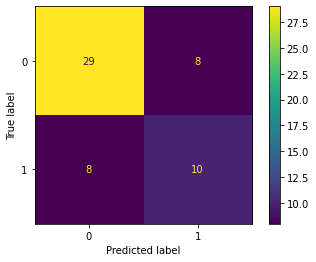

In [295]:
acc_test_1 = accuracy(check)
print(acc_test_1)
cm = make_confusion_matrix(check)
i = make_indicator(cm)
display(i)

####Train Accuracy

In [296]:
check = test(network, x_train, y_train)
print(len(check))
check[:5]

<<  Test Start  >>
 ------------------------------
 ------------------------------
<<  Test End  >>

127


[(0.9119670391082764, array([1.28997053])),
 (-0.8380329608917236, array([-0.80174521])),
 (-0.10463452339172363, array([0.19151236])),
 (0.8338420391082764, array([1.16154383])),
 (-0.35756421089172363, array([-0.37547786]))]

0.9448818897637795


{'TPR': 0.8780487804878049,
 'TNR': 0.9767441860465116,
 'PPV': 0.9473684210526315,
 'NPV': 0.9438202247191011,
 'FNR': 0.12195121951219512,
 'FPR': 0.023255813953488372,
 'FDR': 0.05263157894736842,
 'FOR': 0.056179775280898875,
 'F1': 0.9113924050632911}

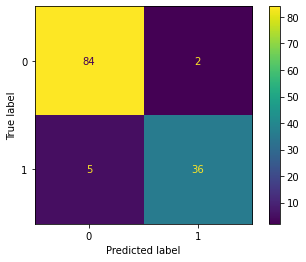

In [297]:
acc_train_1 = accuracy(check)
print(acc_train_1)
cm = make_confusion_matrix(check)
i = make_indicator(cm)
display(i)

#### X:資料量 Y:Hidden node數量

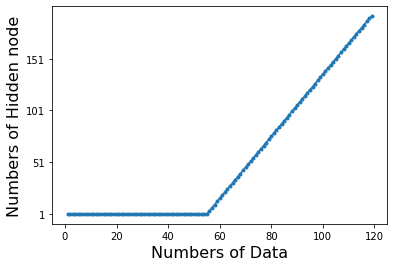

In [298]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.xlabel("Numbers of Data", fontsize=16) #x軸標題
plt.ylabel("Numbers of Hidden node", fontsize=16) #y軸標題
plt.yticks(range(min(num_hiddennodes.values()), max(num_hiddennodes.values())+1,50)) #https://blog.csdn.net/cdqn10086/article/details/77828609
plt.plot(list(num_hiddennodes.keys()),list(num_hiddennodes.values()),'-', marker='.')
plt.show()

####X:資料量 Y:被修剪的node數量

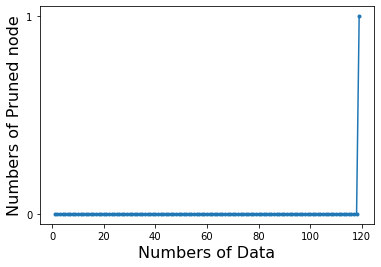

In [299]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.xlabel("Numbers of Data", fontsize=16) #x軸標題
plt.ylabel("Numbers of Pruned node", fontsize=16) #y軸標題
plt.yticks(range(min(reorganizing_sucess.values()), max(reorganizing_sucess.values())+1,1)) #https://blog.csdn.net/cdqn10086/article/details/77828609
plt.plot(list(reorganizing_sucess.keys()),list(reorganizing_sucess.values()),'-', marker='.')
plt.show()

####X:時間(s) Y:Hidden node數量

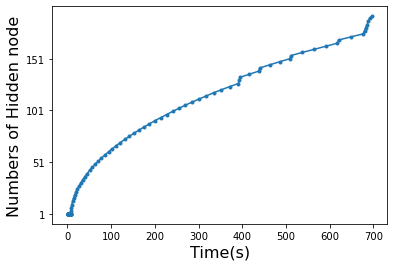

In [300]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.xlabel("Time(s)", fontsize=16) #x軸標題
plt.ylabel("Numbers of Hidden node", fontsize=16) #y軸標題
plt.yticks(range(min(num_hiddennodes.values()), max(num_hiddennodes.values())+1,50))
plt.plot(timestamp,list(num_hiddennodes.values()),'-', marker='.')
plt.show()

###Statistics

In [ ]:
import numpy as np

test_acc =[0.4,0.5,0.49,0.7,0.6,0.53,0.56,0.71,0.62,0.5,0.51,0.64,0.6,0.38,0.58]
train_acc = [1,1,1,1,1,1,1,1,1,1,1,1,1,0.99,1]

display(np.mean(train_acc))
print(np.std(train_acc))
print(np.mean(test_acc))
display(np.std(test_acc))